In [71]:
from tensorflow.python.summary.summary_iterator import summary_iterator

import pandas as pd
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])
log_file_path = "/Users/thomasrochefort/Documents/GitHub/sogym_v2/tb_PPO/events.out.tfevents.1713636502.holodeck.2392170.10"

def read_tensorboard_data(log_file_path, tag_name='eval/mean_reward'):
    """
    Read specified tag data from a TensorBoard log file.

    Parameters:
    log_file_path (str): Path to the TensorBoard log file.
    tag_name (str): Tag of the data to read.

    Returns:
    list of tuples: Each tuple contains (step, value) for the entries under the specified tag.
    """
    data = []
    try:
        for e in summary_iterator(log_file_path):
            for v in e.summary.value:
                if v.tag == tag_name:
                    data.append((e.step, v.simple_value))
    except Exception as ex:
        print(f"Error reading {log_file_path}: {str(ex)}")
    return data

# Retrieve the eval/mean_reward data
eval_data = read_tensorboard_data(log_file_path, 'eval/mean_reward')
#eval_data = read_tensorboard_data(log_file_path, 'rollout/ep_rew_mean')

# Convert the data to a DataFrame
PPO_df = pd.DataFrame(eval_data, columns=['Step', 'Mean Reward'])
PPO_df['PPO Transformed Reward'] = (1/np.exp(1 / PPO_df['Mean Reward']))
# PPO_df['PPO Normalized Transformed Reward'] = PPO_df['Transformed Reward'] / PPO_df['Transformed Reward'].max()
PPO_df['Episodes'] = PPO_df['Step'] /8
# Display the DataFrame
print(PPO_df)

          Step  Mean Reward  PPO Transformed Reward   Episodes
0         4992     0.051529            3.730734e-09      624.0
1         9984     0.024071            9.074985e-19     1248.0
2        14976     0.024071            9.074985e-19     1872.0
3        19968     0.028513            5.866571e-16     2496.0
4        24960     0.014457            9.119815e-31     3120.0
...        ...          ...                     ...        ...
5335  26637312     0.172009            2.986481e-03  3329664.0
5336  26642304     0.172430            3.029226e-03  3330288.0
5337  26647296     0.172430            3.029226e-03  3330912.0
5338  26652288     0.173477            3.137070e-03  3331536.0
5339  26657280     0.172701            3.056929e-03  3332160.0

[5340 rows x 4 columns]


In [72]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import pandas as pd
import os
import numpy as np

def read_tensorboard_data(log_file_path, tag_name='eval/mean_reward'):
    data = []
    try:
        for e in summary_iterator(log_file_path):
            for v in e.summary.value:
                if v.tag == tag_name:
                    # Decode the tensor content
                    value = tf.io.decode_raw(v.tensor.tensor_content, v.tensor.dtype)
                    data.append((e.step, float(value.numpy())))
    except Exception as ex:
        print(f"Error reading {log_file_path}: {str(ex)}")
    return data

def process_tensorboard_directory(directory_path, tag_name='eval/ret/mean'):
    all_data = []
    for filename in os.listdir(directory_path):
        if filename.startswith("events.out.tfevents"):
            file_path = os.path.join(directory_path, filename)
            file_data = read_tensorboard_data(file_path, tag_name)
            all_data.extend(file_data)
    return all_data

# Directory containing the TensorBoard files
log_directory_path = "/Users/thomasrochefort/Documents/GitHub/sogym_v2/tb_dreamerv3"

# Retrieve the data from all files
all_eval_data = process_tensorboard_directory(log_directory_path, 'eval/ret/mean')

# Convert the data to a DataFrame
df = pd.DataFrame(all_eval_data, columns=['Step', 'Mean Reward'])
df.sort_values(by='Step', inplace=True)

# Perform transformations
df['Dreamerv3 Transformed Reward'] = (1 / np.exp(1 / df['Mean Reward']))
# df['Dreamerv3 Normalized Transformed Reward'] = df['Transformed Reward'] / df['Transformed Reward'].max()
df['Episodes'] = df['Step'] / 8

# Display the DataFrame
print(df)

       Step  Mean Reward  Dreamerv3 Transformed Reward  Episodes
15    44560     0.014638                  2.145197e-30    5570.0
16    50880     0.032203                  3.264764e-14    6360.0
17    57328     0.033860                  1.491671e-13    7166.0
18    63712     0.051287                  3.404310e-09    7964.0
19    70096     0.055949                  1.728615e-08    8762.0
..      ...          ...                           ...       ...
140  858432     0.170608                  2.847310e-03  107304.0
141  864832     0.170831                  2.869161e-03  108104.0
142  871104     0.171890                  2.974561e-03  108888.0
143  877264     0.158070                  1.788593e-03  109658.0
144  882960     0.172477                  3.033947e-03  110370.0

[145 rows x 4 columns]


In [73]:
appended_df = pd.concat([df, PPO_df], ignore_index=True)
appended_df.head()
# Find max value between the Dreamerv3 Transformer Reward and the PPO Transformer Reward:

maximum_value = appended_df[['Dreamerv3 Transformed Reward', 'PPO Transformed Reward']].max(axis=0).max()

# Normalize the data
appended_df['normalized_dreamerv3'] = appended_df['Dreamerv3 Transformed Reward'] / maximum_value
appended_df['normalized_ppo'] = appended_df['PPO Transformed Reward'] / maximum_value


In [74]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your DataFrame that has already been loaded with 'Step' and 'Mean Reward'
# Example: Load your DataFrame here if not already loaded
# df = pd.read_csv('path_to_your_data.csv')

#Take only rows with PPO Transformed Reward not NAN:

PPO_data = appended_df[appended_df['normalized_ppo'].notna()]
# Adding a constant to the model (statsmodels does not add it by default)
X = sm.add_constant(PPO_data['Episodes'])  # Predictor
y = PPO_data['normalized_ppo']            # Response

# Fit the linear regression model
model_PPO = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model_PPO.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:         normalized_ppo   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     1941.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:45:06   Log-Likelihood:                 1205.5
No. Observations:                5340   AIC:                            -2407.
Df Residuals:                    5338   BIC:                            -2394.
Df Model:                           1                                         
Covariance Type:            nonrobust  

In [75]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your DataFrame that has already been loaded with 'Step' and 'Mean Reward'
# Example: Load your DataFrame here if not already loaded
# df = pd.read_csv('path_to_your_data.csv')

#Take only rows with PPO Transformed Reward not NAN:

dreamer_data = appended_df[appended_df['normalized_dreamerv3'].notna()]
# Adding a constant to the model (statsmodels does not add it by default)
X = sm.add_constant(dreamer_data['Episodes'])  # Predictor
y = dreamer_data['normalized_dreamerv3']            # Response

# Fit the linear regression model
model_d3 = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model_d3.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                             OLS Regression Results                             
Dep. Variable:     normalized_dreamerv3   R-squared:                       0.796
Model:                              OLS   Adj. R-squared:                  0.795
Method:                   Least Squares   F-statistic:                     558.2
Date:                  Tue, 23 Apr 2024   Prob (F-statistic):           3.17e-51
Time:                          15:45:06   Log-Likelihood:                 193.78
No. Observations:                   145   AIC:                            -383.6
Df Residuals:                       143   BIC:                            -377.6
Df Model:                             1                                         
Covariance Type:     

In [67]:
import matplotlib.pyplot as plt

# Assuming df['Episodes'] and df['Predicted'] are already defined as per your description
appended_df['Predicted'] = model_PPO.predict(X)  # Predicted values for the regression line

plt.figure(figsize=(10, 6))
plt.scatter(df['Episodes'], df['Normalized Transformed Reward'], color='blue', label='Data Points')
plt.plot(df['Episodes'], df['Predicted'], color='red', label='Fitted Regression Line')

# Calculate a position for the annotation
x_pos = df['Episodes'].max() * 0.8  # 80% along the x-axis range
y_pos = df['Predicted'].iloc[(df['Episodes'].searchsorted(x_pos))]  # corresponding y from the model

# Annotation for the slope in scientific notation
slope = model.params['Episodes']
plt.annotate(f'Slope: {slope:.2e}', xy=(x_pos, y_pos), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

plt.title('Linear Regression Analysis')
plt.xlabel('Episodes (in millions)')
plt.ylabel('Normalized Transformed Reward')
plt.legend()
plt.grid()

# Get current x-axis ticks and convert them to millions
current_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_ticks])

plt.show()

KeyError: 'Normalized Transformed Reward'

<Figure size 6000x3600 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt

# Assuming df['Episodes'] and df['Predicted'] are already defined as per your description
df['Predicted'] = model.predict(X)  # Predicted values for the regression line

plt.figure(figsize=(10, 6))
plt.scatter(df['Episodes'], df['Normalized Transformed Reward'], color='blue', label='Data Points')
plt.plot(df['Episodes'], df['Predicted'], color='red', label='Fitted Regression Line')

# Calculate a position for the annotation
x_pos = df['Episodes'].max() * 0.8  # 80% along the x-axis range
y_pos = df['Predicted'].iloc[(df['Episodes'].searchsorted(x_pos))]  # corresponding y from the model

# Annotation for the slope in scientific notation
slope = model.params['Episodes']
plt.annotate(f'Slope: {slope:.2e}', xy=(x_pos, y_pos), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

plt.title('Linear Regression Analysis')
plt.xlabel('Episodes (in millions)')
plt.ylabel('Normalized Transformed Reward')
plt.legend()
plt.grid()

# Get current x-axis ticks and convert them to millions
current_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_ticks])

plt.show()


KeyError: 'Normalized Transformed Reward'

<Figure size 6000x3600 with 0 Axes>

In [153]:
# Create a new DataFrame with the specific X value at which you want to predict the y-value
predict_df = pd.DataFrame({'const': [1], 'Episodes': [100]})  # Note: 'const' column must be included if the model includes it

# Predicting the y-value at X = 100
predicted_value = model.predict(predict_df)
print(f'The predicted y-value at X = 100 is {predicted_value[0]}')

The predicted y-value at X = 100 is 0.07046716740511552


/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/1345796633.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppo_df['Predicted_PPO'] = model_PPO.predict(sm.add_constant(ppo_df['Episodes']))
/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/1345796633.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dreamer_df['Predicted_Dreamer'] = model_d3.predict(sm.add_constant(dreamer_df['Episodes']))
/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/1345796633.py:54

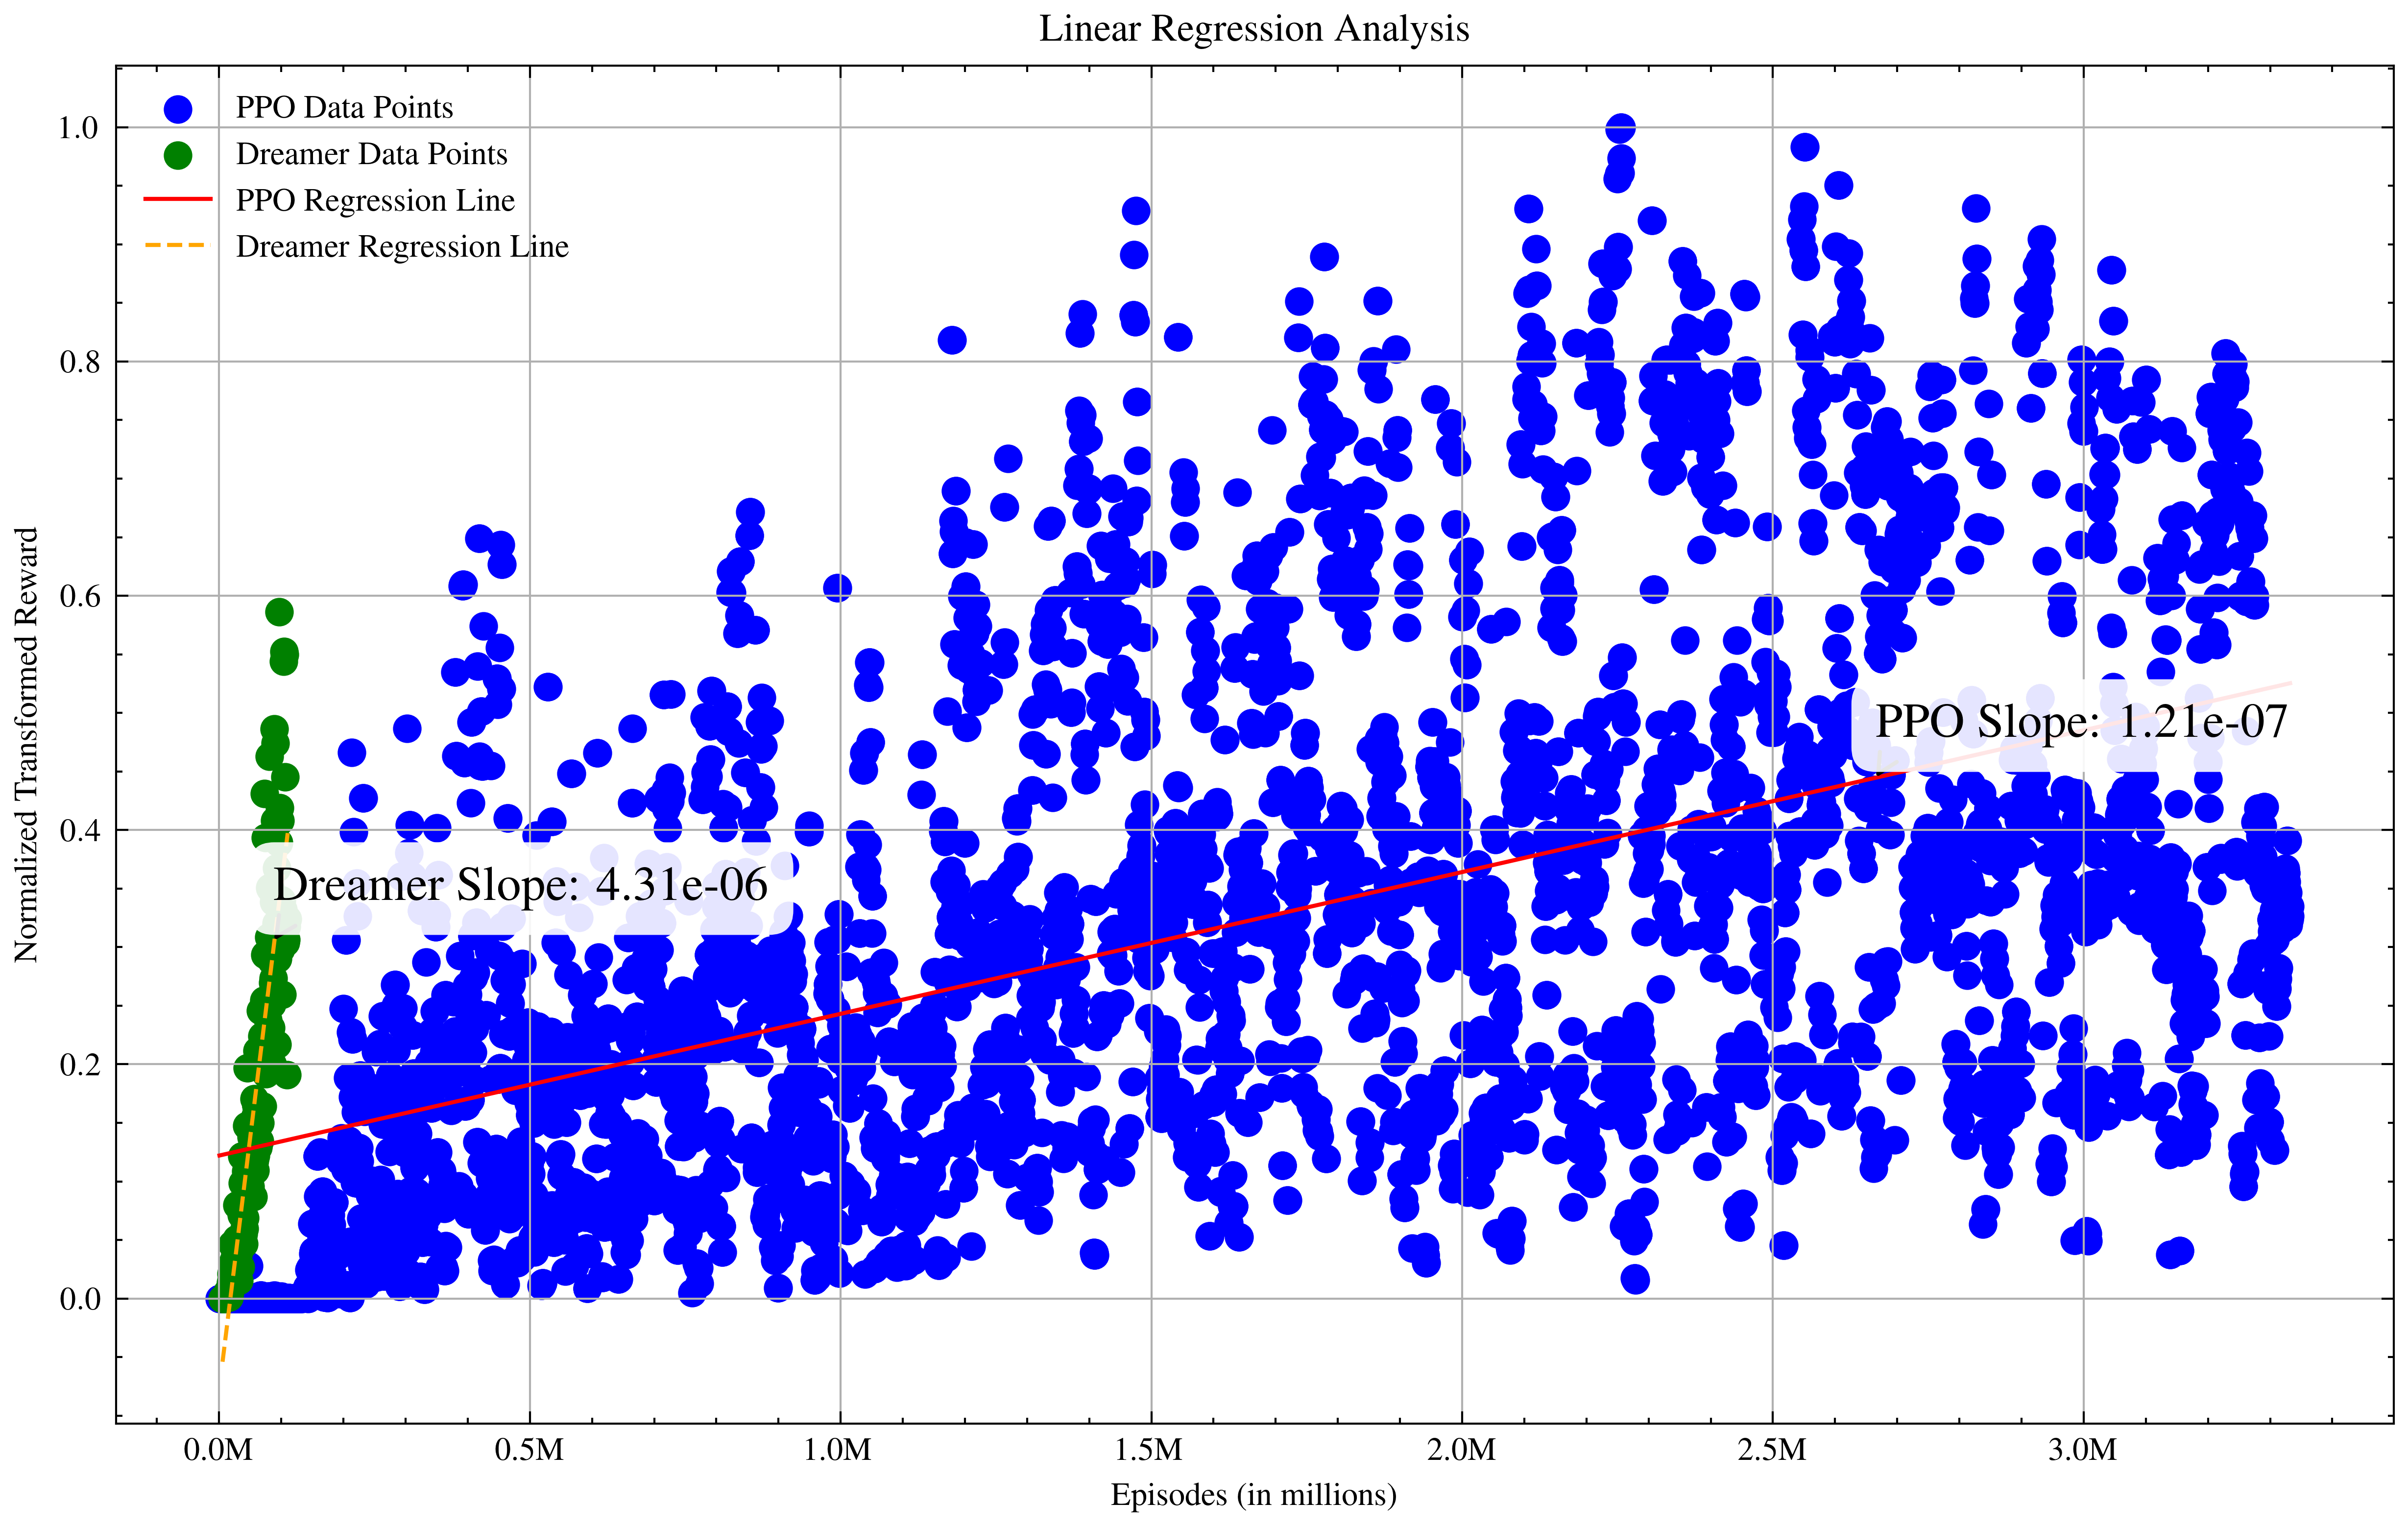

In [76]:
import matplotlib.pyplot as plt

# Assuming appended_df, model_PPO, and model_d3 are already defined as per your description

# Create separate DataFrames for PPO and Dreamer
ppo_df = appended_df[appended_df['normalized_ppo'].notna()]
dreamer_df = appended_df[appended_df['normalized_dreamerv3'].notna()]

# Predict values for the regression lines
ppo_df['Predicted_PPO'] = model_PPO.predict(sm.add_constant(ppo_df['Episodes']))
dreamer_df['Predicted_Dreamer'] = model_d3.predict(sm.add_constant(dreamer_df['Episodes']))

plt.figure(figsize=(10, 6))

# Plot scatter points for PPO
plt.scatter(ppo_df['Episodes'], ppo_df['normalized_ppo'], color='blue', label='PPO Data Points')

# Plot scatter points for Dreamer
plt.scatter(dreamer_df['Episodes'], dreamer_df['normalized_dreamerv3'], color='green', label='Dreamer Data Points')

# Plot regression line for PPO
plt.plot(ppo_df['Episodes'], ppo_df['Predicted_PPO'], color='red', label='PPO Regression Line')

# Plot regression line for Dreamer
plt.plot(dreamer_df['Episodes'], dreamer_df['Predicted_Dreamer'], color='orange', label='Dreamer Regression Line')

# Calculate positions for the annotations
x_pos_ppo = ppo_df['Episodes'].max() * 0.8
y_pos_ppo = ppo_df['Predicted_PPO'].iloc[(ppo_df['Episodes'].searchsorted(x_pos_ppo))]

x_pos_dreamer = dreamer_df['Episodes'].max() * 0.8
y_pos_dreamer = dreamer_df['Predicted_Dreamer'].iloc[(dreamer_df['Episodes'].searchsorted(x_pos_dreamer))]

# Annotation for the slope of PPO in scientific notation
slope_ppo = model_PPO.params['Episodes']
plt.annotate(f'PPO Slope: {slope_ppo:.2e}', xy=(x_pos_ppo, y_pos_ppo), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

# Annotation for the slope of Dreamer in scientific notation
slope_dreamer = model_d3.params['Episodes']
plt.annotate(f'Dreamer Slope: {slope_dreamer:.2e}', xy=(x_pos_dreamer, y_pos_dreamer), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

plt.title('Linear Regression Analysis')
plt.xlabel('Episodes (in millions)')
plt.ylabel('Normalized Transformed Reward')
plt.legend()
plt.grid()

# Get current x-axis ticks and convert them to millions
current_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_ticks])

plt.show()


/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/3867189498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppo_df['Predicted_PPO'] = model_PPO.predict(sm.add_constant(ppo_df['Episodes']))
/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/3867189498.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dreamer_df['Predicted_Dreamer'] = model_d3.predict(sm.add_constant(dreamer_df['Episodes']))
/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/3867189498.py:78

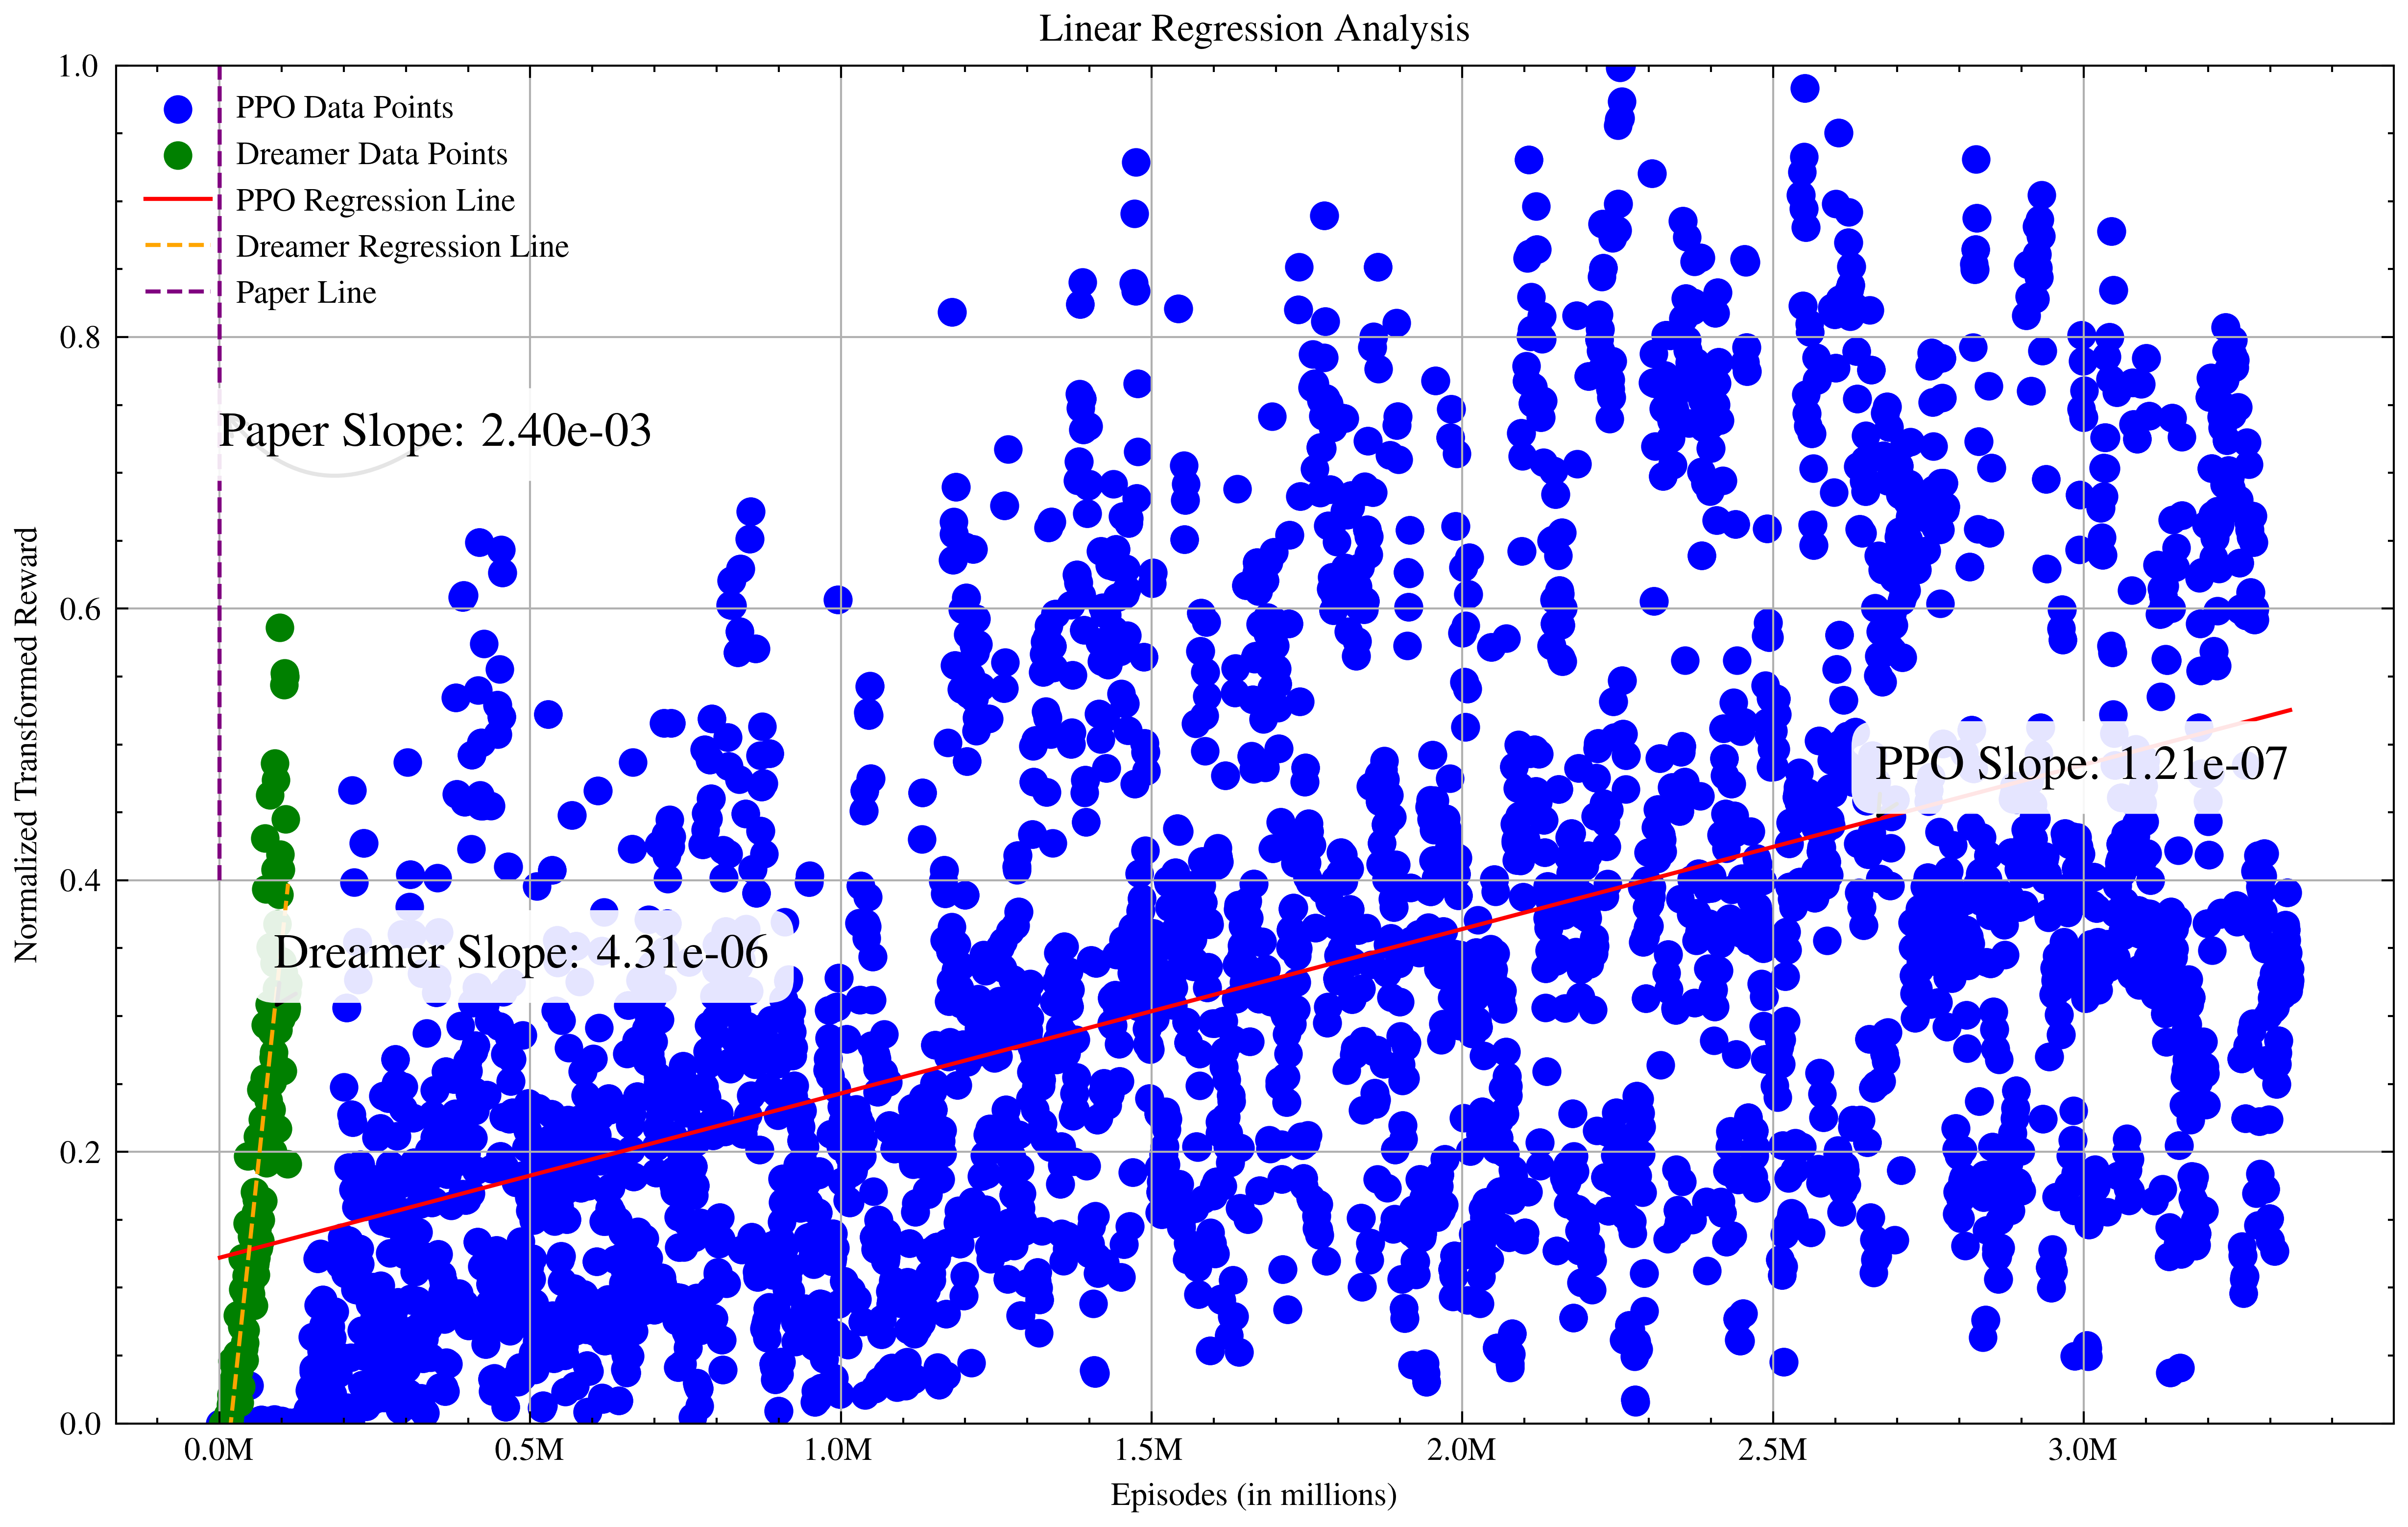

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming appended_df, model_PPO, and model_d3 are already defined as per your description

# Create separate DataFrames for PPO and Dreamer
ppo_df = appended_df[appended_df['normalized_ppo'].notna()]
dreamer_df = appended_df[appended_df['normalized_dreamerv3'].notna()]

# Predict values for the regression lines
ppo_df['Predicted_PPO'] = model_PPO.predict(sm.add_constant(ppo_df['Episodes']))
dreamer_df['Predicted_Dreamer'] = model_d3.predict(sm.add_constant(dreamer_df['Episodes']))

# Slope and intercept from the paper
paper_slope = 0.0024
paper_intercept = 0.40

# Generate x-values for the paper line
paper_x = np.linspace(0, max(ppo_df['Episodes'].max(), dreamer_df['Episodes'].max()), 100)
paper_y = paper_slope * paper_x + paper_intercept

plt.figure(figsize=(10, 6))

# Plot scatter points for PPO
plt.scatter(ppo_df['Episodes'], ppo_df['normalized_ppo'], color='blue', label='PPO Data Points')

# Plot scatter points for Dreamer
plt.scatter(dreamer_df['Episodes'], dreamer_df['normalized_dreamerv3'], color='green', label='Dreamer Data Points')

# Plot regression line for PPO
plt.plot(ppo_df['Episodes'], ppo_df['Predicted_PPO'], color='red', label='PPO Regression Line')

# Plot regression line for Dreamer
plt.plot(dreamer_df['Episodes'], dreamer_df['Predicted_Dreamer'], color='orange', label='Dreamer Regression Line')

# Plot the line from the paper
plt.plot(paper_x, paper_y, color='purple', linestyle='--', label='Paper Line')

# Calculate positions for the annotations
x_pos_ppo = ppo_df['Episodes'].max() * 0.8
y_pos_ppo = ppo_df['Predicted_PPO'].iloc[(ppo_df['Episodes'].searchsorted(x_pos_ppo))]

x_pos_dreamer = dreamer_df['Episodes'].max() * 0.8
y_pos_dreamer = dreamer_df['Predicted_Dreamer'].iloc[(dreamer_df['Episodes'].searchsorted(x_pos_dreamer))]

x_pos_paper =  0.22
y_pos_paper = 0.75

# Annotation for the slope of PPO in scientific notation
slope_ppo = model_PPO.params['Episodes']
plt.annotate(f'PPO Slope: {slope_ppo:.2e}', xy=(x_pos_ppo, y_pos_ppo), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

# Annotation for the slope of Dreamer in scientific notation
slope_dreamer = model_d3.params['Episodes']
plt.annotate(f'Dreamer Slope: {slope_dreamer:.2e}', xy=(x_pos_dreamer, y_pos_dreamer), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

# Annotation for the slope from the paper
plt.annotate(f'Paper Slope: {paper_slope:.2e}', xy=(x_pos_paper, min(1.0, y_pos_paper)), textcoords="offset points", xytext=(0,-10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

plt.title('Linear Regression Analysis')
plt.xlabel('Episodes (in millions)')
plt.ylabel('Normalized Transformed Reward')

# Set y-axis limits from 0.0 to 1.0
plt.ylim(0.0, 1.0)

plt.legend()
plt.grid()

# Get current x-axis ticks and convert them to millions
current_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_ticks])

plt.show()
